# Imports

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import ast
from textblob import TextBlob
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

Data sets

In [36]:
df_ted_main = pd.read_csv("data/ted_main.csv")
df_ted_transcripts = df = pd.read_csv("data/transcripts.csv")

Drop columns we don't use from ted_main

In [37]:
df_ted_main.drop(['description', 'film_date', 'main_speaker', 'name', 'event', 'num_speaker', 'related_talks', 'speaker_occupation', 'title', 'url'], axis=1, inplace=True)
df_ted_main.head()

,comments,duration,languages,published_date,ratings,tags,views
0,4553,1164,60,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","['children', 'creativity', 'culture', 'dance',...",47227110
1,265,977,43,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","['alternative energy', 'cars', 'climate change...",3200520
2,124,1286,26,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","['computers', 'entertainment', 'interface desi...",1636292
3,200,1116,35,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","['MacArthur grant', 'activism', 'business', 'c...",1697550
4,593,1190,48,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","['Africa', 'Asia', 'Google', 'demo', 'economic...",12005869


# Preprocessing and analysis
## One hot encoding

One hot encoding tags
- iterate through the dataset to change string formed list into normal list and
- replacing string version of a list for the list type

In [38]:
for i, row in df_ted_main.iterrows():
    element_list_form = ast.literal_eval(df_ted_main.at[i,'tags'])
    element_list_form = [i.strip() for i in element_list_form]
    
    df_ted_main.at[i,'tags'] = element_list_form

One hot encoding with column named "tags"
- since "tags" is a series on each row, we need to split them first and then we can do one hot encoding

In [39]:
df_ted_main = df_ted_main.drop('tags', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_ted_main.tags.tolist()).stack()
    ).astype(int).sum(level=0)
)

df_ted_main.head()

,comments,duration,languages,published_date,ratings,views,3d printing,AI,AIDS,Addiction,...,wikipedia,wind energy,women,women in business,work,work-life balance,world cultures,writing,wunderkind,youth
0,4553,1164,60,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",47227110,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,265,977,43,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",3200520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124,1286,26,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",1636292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,200,1116,35,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",1697550,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,593,1190,48,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...",12005869,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Rating analysis

In [40]:
df_ted_main['ratings']=df_ted_main['ratings'].str.replace("'",'"')

df_ted_main=df_ted_main.merge(df_ted_main.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

df_ted_main.drop('ratings', axis=1, inplace=True)

df_ted_main.head()

,comments,duration,languages,published_date,views,3d printing,AI,AIDS,Addiction,Africa,...,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring
0,4553,1164,60,1151367060,47227110,0,0,0,0,0,...,387,242,7346,10581,300,10704,4439,1174,209,24924
1,265,977,43,1151367060,3200520,0,0,0,0,0,...,113,62,443,132,258,268,116,203,131,413
2,124,1286,26,1151367060,1636292,0,0,0,0,0,...,78,27,395,166,104,230,54,146,142,230
3,200,1116,35,1151367060,1697550,0,0,0,0,0,...,53,32,380,132,36,460,230,85,35,1070
4,593,1190,48,1151440680,12005869,0,0,0,0,1,...,110,72,5433,4606,67,2542,3736,248,61,2893


## Sentiment analysis of transcript

In [41]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_ted_transcripts['polarity'] = df_ted_transcripts['transcript'].apply(pol)
df_ted_transcripts['subjectivity'] = df_ted_transcripts['transcript'].apply(sub)
df_ted_transcripts.head()

,transcript,url,polarity,subjectivity
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,0.146452,0.462051
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,0.157775,0.424101
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,0.136579,0.475229
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,0.082928,0.439165
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,0.096483,0.450631


Merging both data sets and deleting the rows which don't have a transcript

In [42]:
df_ted_talks = pd.merge(df_ted_main, df_ted_transcripts, left_index=True, right_index=True)

Deleting rows

In [43]:
del df_ted_talks['transcript']
del df_ted_talks['url']
df_ted_talks.head()

,comments,duration,languages,published_date,views,3d printing,AI,AIDS,Addiction,Africa,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,polarity,subjectivity
0,4553,1164,60,1151367060,47227110,0,0,0,0,0,...,7346,10581,300,10704,4439,1174,209,24924,0.146452,0.462051
1,265,977,43,1151367060,3200520,0,0,0,0,0,...,443,132,258,268,116,203,131,413,0.157775,0.424101
2,124,1286,26,1151367060,1636292,0,0,0,0,0,...,395,166,104,230,54,146,142,230,0.136579,0.475229
3,200,1116,35,1151367060,1697550,0,0,0,0,0,...,380,132,36,460,230,85,35,1070,0.082928,0.439165
4,593,1190,48,1151440680,12005869,0,0,0,0,1,...,5433,4606,67,2542,3736,248,61,2893,0.096483,0.450631


## Split data set

A feature we want to predict: views, and removing feature we want to predict from the original data set

In [44]:
labels = np.array(df_ted_talks['views'])

df_ted_talks = df_ted_talks.drop('views', axis = 1)

Splitting

In [45]:
# Splitting
train_set, test_set, train_labels, test_labels = train_test_split(df_ted_talks, labels, test_size = 0.14, random_state = 42)

## Standardization

Fit on training set only

In [46]:
scaler = StandardScaler()
scaler.fit(train_set)

StandardScaler()

Apply transform to both the training set and the test set

In [47]:
df_train_set_scaled = scaler.transform(train_set)
df_test_set_scaled = scaler.transform(test_set)

Convert to data frames

In [48]:
df_train_set = pd.DataFrame(df_train_set_scaled, index=train_set.index, columns=train_set.columns)
df_test_set = pd.DataFrame(df_test_set_scaled, index=test_set.index, columns=test_set.columns)

## Principal Component Analysis
### Getting tag columns
Columns without PCA

In [49]:
columns_without_pca = ['views','subjectivity','polarity','Inspiring','Obnoxious','OK',
                                  'Jaw-dropping','Persuasive','Unconvincing','Fascinating','Informative','Confusing',
                                  'Longwinded','Courageous','Ingenious','Beautiful','Funny','comments','duration',
                                  'languages','published_date']

Get tag columns for both training set and test set

In [50]:
tag_columns_train_set = df_train_set[df_train_set.columns.difference(columns_without_pca)]
tag_columns_test_set = df_test_set[df_test_set.columns.difference(columns_without_pca)]

Saving indexes of training set and test set for the next step.
PCA will convert dataframe into numpy array and indexes will be lost.
This way we will keep them stored.
1. Save tag columns as tag_columns_train_set_indexes and tag_columns_test_set_indexes
2. Save all tag columns as lists
3. Remove tag columns from original sets

In [51]:
tag_columns_train_set_indexes = tag_columns_train_set.index
tag_columns_test_set_indexes = tag_columns_test_set.index

tag_columns_train_set_list = list(tag_columns_train_set)
tag_columns_test_set_list = list(tag_columns_test_set)

df_train_set.drop(tag_columns_train_set_list, axis=1, inplace=True)
df_test_set.drop(tag_columns_test_set_list, axis=1, inplace=True)

### Launch PCA

In [52]:
pca = PCA(.80)

Fit PCA only on training set of tag columns and use PCA to transform both sets of tag columns

In [53]:
pca.fit(tag_columns_train_set)

tag_columns_train_set = pca.transform(tag_columns_train_set)
tag_columns_test_set = pca.transform(tag_columns_test_set)

Combine PCA transformed training set and test set of tag columns with original training set and test set

In [54]:
feat_cols_train = ['feature'+str(i) for i in range(tag_columns_train_set.shape[1])]
df_pca_train = pd.DataFrame(tag_columns_train_set, columns=feat_cols_train, index=tag_columns_train_set_indexes)

feat_cols_test = ['feature'+str(i) for i in range(tag_columns_test_set.shape[1])]
df_pca_test = pd.DataFrame(tag_columns_test_set, columns=feat_cols_test, index=tag_columns_test_set_indexes)


Result of combining

In [55]:
df_train_set = df_train_set.join(df_pca_train, how="left")
df_test_set = df_test_set.join(df_pca_test, how="left")

In [56]:
df_train_set

,comments,duration,languages,published_date,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,...,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225
48,-0.375239,-1.531568,0.670963,-1.867001,1.243774,0.452846,0.730267,-0.276685,0.168514,0.726681,...,1.194613,-0.533931,-0.409992,-0.518119,0.675437,1.003069,-0.082645,0.873226,-1.603929,-0.877023
679,-0.280271,1.425466,-0.208791,-0.708059,-0.254112,-0.319885,-0.126975,-0.276685,0.051542,-0.424790,...,-1.029356,-0.072929,-0.602938,0.193162,0.709888,0.106545,-0.648480,0.347846,0.078507,0.226713
1624,-0.257479,-0.144803,0.451024,0.496605,-0.257279,-0.402451,-0.429335,-0.307296,-0.650286,-0.549273,...,0.060098,0.343435,0.731605,-0.357271,0.150030,0.782105,-0.808015,-0.194959,0.566875,0.053109
1486,-0.257479,-1.023001,-3.067993,0.305806,-0.062522,-0.355876,-0.293107,-0.357585,-0.392949,0.135385,...,-0.366098,0.857397,2.430861,2.102511,0.829500,-0.735905,1.409509,0.497287,0.190304,0.498421
1607,0.050216,-0.362387,0.011147,0.475066,-0.254112,-0.385515,-0.475852,-0.344466,-0.580103,-0.455911,...,0.116628,0.209272,-0.400821,-0.009747,-0.601767,0.304213,0.125936,0.122694,0.232107,-0.035640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.224956,0.067537,0.121117,0.517178,-0.246195,-0.332588,0.015899,-0.191412,-0.533315,-0.518153,...,0.063512,0.553904,0.398118,0.615934,-0.375561,-0.911442,0.210257,0.827538,0.429053,-0.750875
1095,0.642813,0.762230,0.451024,-0.154221,-0.243028,-0.298715,-0.210041,-0.333534,2.695096,1.473582,...,-0.468156,1.499524,0.786361,-0.765274,1.197969,-0.880929,-1.510591,-0.027284,0.928786,0.925685
1130,-0.496797,-0.388601,-0.098822,-0.112125,-0.255695,-0.385515,-0.090426,-0.346653,-0.626892,-0.611515,...,0.466291,0.329946,-0.026339,0.274013,-0.300074,-0.386844,1.351000,-0.241806,-0.175458,-0.429549
1294,-0.481602,0.043944,-0.758638,0.047719,-0.257279,-0.381281,0.105610,-0.322601,-0.673680,-0.611515,...,-0.046188,0.082760,0.086588,-0.149821,0.269496,-0.278235,0.177238,-0.146161,0.131282,0.185602


In [57]:
df_test_set

,comments,duration,languages,published_date,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,...,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225
1711,-0.090336,-0.608806,0.451024,0.624667,-0.222444,1.071031,-0.465884,1.743636,-0.416343,0.042023,...,0.633547,2.571862,-0.019691,1.413999,-0.804681,2.058144,-0.441086,1.422541,1.026234,-1.457140
1557,-0.120726,-0.490839,0.341055,0.396513,-0.252528,-0.286012,-0.093748,0.011932,-0.790652,-0.580394,...,0.249341,0.821272,0.651633,0.324193,1.038629,-0.675183,-0.559964,-0.609927,-0.424244,0.545533
1870,-0.344849,0.429302,0.011147,0.847260,-0.241445,-0.099710,-0.455916,-0.023051,-0.580103,-0.362548,...,-0.386335,-0.570781,0.102614,-0.541950,0.555364,0.085721,-1.568281,3.047928,0.173815,-0.628113
1703,0.080606,0.366386,0.231086,0.614397,-0.239861,-0.368578,-0.465884,0.079714,-0.416343,-0.331427,...,-0.537333,0.356057,-0.277620,0.871180,0.731046,0.860685,0.413392,1.078597,-1.405438,0.085859
1857,-0.455011,-0.642885,0.560994,0.829513,-0.181276,-0.036198,-0.346269,-0.121444,-0.065429,0.197627,...,-0.658828,0.492414,-0.212262,0.239458,0.186853,-0.241365,0.036808,-0.058318,-0.265986,0.344530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1.216417,0.531540,0.451024,-0.226262,-0.165442,0.219968,-0.382818,-0.066781,0.589611,0.508835,...,-0.046918,0.375881,0.876352,-0.736308,0.207412,0.578856,-0.240264,-0.377411,0.193368,-0.533544
49,0.019826,-1.660021,2.210533,-1.867001,-0.173359,-0.393983,-0.419367,-0.305109,-0.603498,0.197627,...,0.683610,1.123149,0.016965,-0.382436,0.878370,-0.096037,1.406211,2.306507,-1.046252,-0.651054
67,0.099599,0.497460,0.341055,-1.762270,0.984098,-0.209798,0.952884,-0.173920,0.285485,0.042023,...,0.784314,-1.422447,0.376314,0.232872,-1.062062,-0.174917,0.596293,-0.050229,0.525913,0.773808
1963,-0.086537,-1.361172,0.670963,0.987492,-0.231944,1.058328,-0.369528,1.312897,-0.392949,-0.144702,...,-0.976095,-0.812571,0.216821,1.080045,-1.110833,0.060309,0.840251,0.939807,0.172645,-0.123979


In [58]:
df_train_set.shape

(2121, 246)

In [59]:
df_test_set.shape

(346, 246)

In [60]:
df_train_set.isnull().values.any()

False

In [61]:
df_test_set.isnull().values.any()

False

# Predicting

In [62]:
rf = RandomForestRegressor(criterion='mae',max_depth=25, max_features=70, n_estimators=70, random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()  

model_dic = {"Random Forest": rf, "Gradient Booster": gbr, 'Linear Regression': lr}
names = []
scores = []

for name, model in model_dic.items():
    # Train the model on training data
    model.fit(df_train_set, train_labels)
    # Predict on test set
    model.predict(df_test_set)
    # get the score
    score = model.score(df_test_set, test_labels)
    # save the name and the score
    names.append(name)
    scores.append(score)

Visualize

In [63]:
vis_data = {'Model':names, 'Score':scores} 
vis_df = pd.DataFrame(vis_data) 
vis_df

,Model,Score
0,Random Forest,0.688036
1,Gradient Booster,0.748336
2,Linear Regression,0.715543


In [64]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

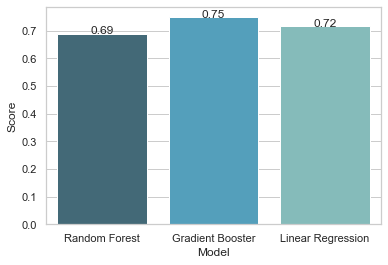

In [65]:
sns.set(style="whitegrid")

ax = sns.barplot("Model", y="Score", data=vis_df,
                 palette="GnBu_d")

show_values_on_bars(ax)

In [66]:
importances = pd.DataFrame({'Feature': df_train_set.columns, 
                                'Importance': gbr.feature_importances_})

importances_ratings = importances[4:18]
importances_ratings_sorted = importances_ratings.sort_values(by=['Importance'], axis='index', ascending=False)
importances_ratings_sorted

,Feature,Importance
17,Inspiring,0.369939
11,Fascinating,0.176017
15,OK,0.098279
10,Informative,0.078969
13,Persuasive,0.069316
4,Funny,0.047603
14,Jaw-dropping,0.012748
7,Courageous,0.011294
16,Obnoxious,0.010477
5,Beautiful,0.006931
